# Challenge 1
## Below are some code to help you get started with manipulating the data and plot the time series. You may use them to manually identify thief hatch open and close events.

In [46]:
import pandas as pd
from datetime import datetime
from glob import glob

# get tank header pressure
df_thp = []
for f in glob('data/tank_header_pressure_*.csv'):
    df_thp.append(pd.read_csv(f))

df_thp = pd.concat(df_thp)
#df_thp.info()

In [47]:
#facility to look at:
facility_id = 10085460

#get data for specified facility
df_thp_460 = df_thp[df_thp.FACILITY_ID == facility_id].copy()
df_thp_460.timestamp = pd.to_datetime(df_thp_460.timestamp)

from utils import plot_ts_open_hatch
fig = plot_ts_open_hatch(dfi=df_thp_460, fac_id=facility_id)
fig.write_image(f'results/challenge_1/{facility_id}.png')
fig.show()

In [48]:
# get drone data 
df_drone = pd.read_csv('data/drone.csv')

# get drone data for specified facility
df_drone_460 = df_drone[df_drone.FACILITY_ID == facility_id]

t_drone_open_hatch = None
if not df_drone_460.empty:
    t_drone_open_hatch = pd.to_datetime(df_drone_460.DTM.iloc[0])

df_drone_460

ASSET                      DTM  FACILITY_ID
27  Permian  2022-08-19 13:49:00.000     10085460

In [49]:
from datetime import timedelta 

# get work order data to check whether and when hatch was closed
df_workorder = pd.read_csv('data/work_order.csv')
df_workorder.facility_id = df_workorder.facility_id.fillna(0).astype(int) #for wells

# get work order data for specific facility
df_workorder_460 = df_workorder[df_workorder.facility_id == facility_id]

# filter rows containing key word 'hatch', keyword could be 'thief' or misspelled words
# looks for workOrderDesc or workOrderResDesc for hatch and puts in df
df_workorder_460 = df_workorder_460[(df_workorder_460.workOrderDescription.fillna('').str.lower().str.contains('hatch'))
                | ((df_workorder_460.workOrderResolutionDescription.fillna('').str.lower().str.contains('hatch')))]

# filter rows with dates within drone detected open hatch date
# turns series data into TimeStampSeries data
df_workorder_460.created_date = pd.to_datetime(df_workorder_460.created_date)
df_workorder_460.workOrderActualsStartDate = pd.to_datetime(df_workorder_460.workOrderActualsStartDate)
df_workorder_460.workOrderActualsEndDate = pd.to_datetime(df_workorder_460.workOrderActualsEndDate)

#if there is drone data, get workorder data near the drone time
if t_drone_open_hatch is not None:
    t_workorder_strt = t_drone_open_hatch - timedelta(days=30)
    t_workorder_stop = t_drone_open_hatch + timedelta(days=30)

    df_workorder_460 = df_workorder_460[
        df_workorder_460.created_date.between(t_workorder_strt, t_workorder_stop)
        | df_workorder_460.workOrderActualsStartDate.between(t_workorder_strt, t_workorder_stop)
        | df_workorder_460.workOrderActualsEndDate.between(t_workorder_strt, t_workorder_stop)
    ]
df_workorder_460

created_date assetType sourceSystemId  facility_id corp_id  \
192845   2022-08-24  Facility       10085460     10085460     NaN   

                                     workOrderDescription  \
192845  Got a drone finding indicating there’s an open...   

       workOrderResolutionDescription workOrderActualsStartDate  \
192845  Thief hatch has been closed.                        NaT   

       workOrderActualsEndDate  
192845              2022-08-25

In [50]:
# get forms data
df_form = pd.read_csv('data/forms.csv').sort_values(by='SubmitDate')
df_form_460 = df_form[df_form.FACILITY_ID == facility_id]
df_form_460

Empty DataFrame
Columns: [SubmitDate, VisibleFlare, ThiefHatchClosed, OpenThiefHatchClosed, IssueDetail, BusinessUnit, FACILITY_ID]
Index: []

In [51]:
# plot pressure with drone detected open hatch time, you may add hatch open or close time from work order or Forms data or other notes to the plot.
fig = plot_ts_open_hatch(dfi=df_thp_460, fac_id=facility_id, t_drone_open_hatch=t_drone_open_hatch, plot_dir='results/challenge_1')
fig.show()

In [52]:
#NOTE: this is just the data that we could back up with drone or workorder data

#manually identified data:
facility_id_identified = ['10085460','10085941','10085510','10086098','10085544']
t_hatch_open_manual = ['2022-07-05 15:14:00','2021-10-19 22:42:00','2022-02-14 16:43:21','2022-07-24 21:12:00','2022-10-13 20:40:25']
t_hatch_closed_manual = ['2022-08-25 21:14:00','2021-10-28 14:57:00','2022-05-13 15:28:13','2022-09-21 16:57:54','2022-11-27 16:55:24']
t_hatch_open_drone = ['2022-08-19 13:49:00','2021-10-20 18:27:00','null','2022-08-19 13:11:00','null']
t_hatch_closed_drone = ['null','null','null','null','null']
t_hatch_open_work_order = ['null','null','null','null','null']
t_hatch_closed_work_order = ['2022-08-25 12:00:00','null','2020-05-16 12:00:00','2022-08-25 12:00:00','2022-11-07 12:00:00']
t_hatch_open_forms = ['null','null','null','null','null']
t_hatch_closed_forms = ['null','null','null','null','null']

#write to dataframe
open_hatch_events_manual = pd.DataFrame({'facility_id':facility_id_identified,'t_hatch_open_manual':t_hatch_open_manual,'t_hatch_closed_manual':t_hatch_closed_manual,'t_hatch_open_drone':t_hatch_open_drone,'t_hatch_closed_drone':t_hatch_closed_drone,'t_hatch_open_work_order':t_hatch_open_work_order,'t_hatch_closed_work_order':t_hatch_closed_work_order,'t_hatch_open_forms':t_hatch_open_forms,'t_hatch_closed_forms':t_hatch_closed_forms}) 

# it should include 9 columns of 
# facility_id, 
# time when hatch opened(identified manually), time when hatch closed(identified manually),
# time when hatch was opened(from drone data), time when hatch was close(from drone data), 
# time when hatch opened(from work orders data), time when hatch opened(from work order data),
# time when hatch opened(from forms data), time when hatch opened(from forms data),

#save dataframe as .csv
open_hatch_events_manual.to_csv('results/challenge_1/open_hatch_events_manual.csv',index=False)
open_hatch_events_manual

facility_id  t_hatch_open_manual t_hatch_closed_manual   t_hatch_open_drone  \
0    10085460  2022-07-05 15:14:00   2022-08-25 21:14:00  2022-08-19 13:49:00   
1    10085941  2021-10-19 22:42:00   2021-10-28 14:57:00  2021-10-20 18:27:00   
2    10085510  2022-02-14 16:43:21   2022-05-13 15:28:13                 null   
3    10086098  2022-07-24 21:12:00   2022-09-21 16:57:54  2022-08-19 13:11:00   
4    10085544  2022-10-13 20:40:25   2022-11-27 16:55:24                 null   

  t_hatch_closed_drone t_hatch_open_work_order t_hatch_closed_work_order  \
0                 null                    null       2022-08-25 12:00:00   
1                 null                    null                      null   
2                 null                    null       2020-05-16 12:00:00   
3                 null                    null       2022-08-25 12:00:00   
4                 null                    null       2022-11-07 12:00:00   

  t_hatch_open_forms t_hatch_closed_forms  
0               null                 null  
1               null                 null  
2               null                 null  
3               null                 null  
4               null                 null

# Challenge 2
## Develop algorithm to classify time series data to determine whether thief hatch is open or not at any given time

In [53]:
from models import model_ground_truth, model_predict_open_hatch
import keras

df = df_thp_460.copy()
pred_freq = timedelta(hours=4) # Predict every 4 hours

#automatically set start and stop time
# t_strt = df.timestamp.iloc[0]
# t_strt = datetime(*t_strt.timetuple()[:4])
# t_strt += pred_freq 
# t_stop = df.timestamp.iloc[-1]
# t_stop = datetime(*t_stop.timetuple()[:4])
# t_stop -= pred_freq

#manually set start and stop time
t_strt = pd.to_datetime("2022-06-28")
t_stop = pd.to_datetime("2022-09-01")

t_strt_0 = t_strt
df = df[df.timestamp.between(t_strt, t_stop)]

#load the neural network so it doesn't have to load every time (note: this is for predicting only)
model = keras.models.load_model("models/model", custom_objects={"error":(lambda x, y: 0)})

df_pred = []
totalPredictions = (t_stop-t_strt)//pred_freq
i = 0
while t_strt <= t_stop:
    
    #add a new datapoint with prediction
    df_pred.append([t_strt, model_ground_truth(df, t_strt)] + model_predict_open_hatch(df, t_strt, model))
    print(f"\r{i}/{totalPredictions}", end='')

    t_strt += pred_freq
    i += 1

#write data to a dataframe
df_pred = pd.DataFrame(df_pred, columns = ['TimeStamp', 'Status_Truth', 'Status_Predicted', 'Model_Confidence']) 

print("\ndone")

390/390
done


In [54]:
#plot data, truth, prediction, and confidence
from utils import plot_prediction_validation

fig = plot_prediction_validation(df, df_pred, facility_id)
fig.write_image(f'results/challenge_2/prediction_validation_{facility_id}.png')
fig.show()

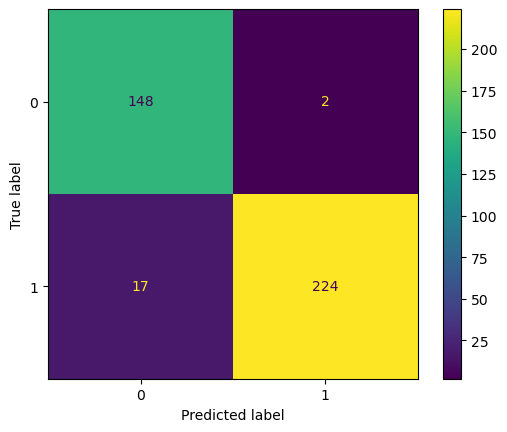

In [55]:
# calculate classification metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score
conf_matrix = confusion_matrix(df_pred.Status_Truth, df_pred.Status_Predicted)
ConfusionMatrixDisplay(conf_matrix).plot()

In [56]:
# store scores for each "facility_id, df.timestamp.min(), df.timestamp.max()"
scores = [facility_id, t_strt_0, t_stop, pred_freq, df_pred.shape[0], 
          accuracy_score(df_pred.Status_Truth, df_pred.Status_Predicted),
          recall_score(df_pred.Status_Truth, df_pred.Status_Predicted),
          precision_score(df_pred.Status_Truth, df_pred.Status_Predicted),
          f1_score(df_pred.Status_Truth, df_pred.Status_Predicted)
          ]

scores = pd.DataFrame([scores], columns = ['facility_id', 't_strt', 't_stop', 'pred_freq', 'pred_#', 'accuracy_score', 'recall_score', 'precision_score', 'f1_score'])

scores.to_csv('results/challenge_2/model_predictions.csv', index=False)

# Challenge 3
## Use the algorithm you developed or new algorithm to identify retrospectively open thief hatches in the past that’s not detected by drone

In [57]:
from models import search_for_open_hatch

search_res = []

i = 0
total_facilitites = len(df_thp.FACILITY_ID.unique())
for fac_id in df_thp.FACILITY_ID.unique():
    #only search the first 20 facilities
    if i > 20: break

    df = df_thp[df_thp.FACILITY_ID == fac_id]

    events = search_for_open_hatch(df, fac_id)
    
    print(f"\r{i}/{total_facilitites} facilities searched", end='')
    search_res +=events
    i += 1

search_res = pd.DataFrame(search_res, columns = ['facility_id', 'num_of_open_hatch_events', 'open_hatch_event_seq', 't_hatch_open', 't_hacth_clos'])
search_res.to_csv('results/challenge_3/search_results.csv', index=False)
print("\ndone")
search_res

20/142 facilities searched
done


facility_id  num_of_open_hatch_events  open_hatch_event_seq t_hatch_open  \
0      10085682                         1                     0   2023-01-10   
1      10085526                         1                     0   2023-01-04   
2      10085845                         4                     0   2022-07-18   
3      10085845                         4                     1   2022-07-26   
4      10085845                         4                     2   2022-09-04   
5      10085845                         4                     3   2022-09-20   
6      10197929                         5                     0   2022-02-13   
7      10197929                         5                     1   2022-06-13   
8      10197929                         5                     2   2022-08-04   
9      10197929                         5                     3   2022-09-05   
10     10197929                         5                     4   2022-11-20   
11     10085805                         1                     0   2022-02-23   
12     10085810                         3                     0   2021-10-15   
13     10085810                         3                     1   2021-10-29   
14     10085810                         3                     2   2021-11-12   
15     10085554                         1                     0   2022-05-25   
16     10085986                         1                     0   2023-02-24   
17     10085678                         2                     0   2022-11-27   
18     10085678                         2                     1   2022-12-09   
19     10085551                         3                     0   2022-08-03   
20     10085551                         3                     1   2022-08-17   
21     10085551                         3                     2   2022-08-31   
22     10085776                         2                     0   2022-10-15   
23     10085776                         2                     1   2022-11-24   

   t_hacth_clos  
0    2023-02-24  
1    2023-02-25  
2    2022-07-24  
3    2022-08-17  
4    2022-09-14  
5    2022-09-30  
6    2022-06-11  
7    2022-08-02  
8    2022-08-22  
9    2022-11-18  
10   2023-01-24  
11   2022-03-01  
12   2021-10-21  
13   2021-11-10  
14   2021-12-08  
15   2022-08-05  
16   2023-02-25  
17   2022-12-03  
18   2022-12-15  
19   2022-08-11  
20   2022-08-29  
21   2023-02-25  
22   2022-10-21  
23   2022-12-02

In [58]:

search_res_plot = search_res.iloc[:100] # limit what and how many to plot

for _, fac_id, num_of_open_hatch_events, open_hatch_event_seq, t_hatch_open, t_hacth_clos in search_res_plot.itertuples():
    
    dfi = df_thp[df_thp.FACILITY_ID==fac_id].copy()

    # ensure in datetime format
    t_hatch_open = pd.to_datetime(t_hatch_open)
    t_hacth_clos = pd.to_datetime(t_hacth_clos)

    t_strt = t_hatch_open - timedelta(days=30)
    t_stop = t_hacth_clos + timedelta(days=30)
    
    dfi.timestamp = pd.to_datetime(dfi.timestamp)
    dfi = dfi[dfi.timestamp.between(t_strt, t_stop)] # limit the dataframe 

    fig = plot_ts_open_hatch(dfi=dfi, fac_id=facility_id)
    fig.update_layout(title=f'{fac_id}-[{open_hatch_event_seq:01}-{num_of_open_hatch_events:01}], hatch open: {t_hatch_open}, hatch close: {t_hacth_clos}')
    fig.write_image(f'results/challenge_3/imgs_search_results/{fac_id}-[{open_hatch_event_seq:01}-{num_of_open_hatch_events:01}].png', engine='orca')

In [59]:
print('Good luck!')

Good luck!
